In [1]:
import os 
os.listdir()

['train.csv',
 'DataCleaning.ipynb',
 'PA_201605-2012001更新R6(20190509).xlsx',
 'tag盤點表.xlsx',
 'xgboost.ipynb',
 'train_FeatureSelected.csv',
 'feature select.ipynb',
 'tpot_pa_pipeline.py',
 'TPOT.ipynb',
 'cnn-time-stack.ipynb',
 '.ipynb_checkpoints']

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from tqdm import tqdm_notebook as tqdm

# load

In [3]:
df = pd.read_csv('train.csv',index_col = 0,parse_dates = True)
print(df.shape)
df.head()

(193825, 93)


,MLPAP_TI-0706B02,MLPAP_TI-0706B03,MLPAP_TI-0706B04,MLPAP_TI-0706B05,MLPAP_TI-0706B06,MLPAP_TI-0706B07,MLPAP_TI-0706B08,MLPAP_TI-0706B09,MLPAP_TI-0706B10,MLPAP_TI-0706B11,...,MLPAP_FQI-0997.PV,DATA OF USE,MLPAP_FR-0755.PV,MLPAP_FR-0755PV(轉換後),MLPAP_FR-0791.PV,MLPAP_FI-V211.PV,MLPAP_FI-V211.PV(轉換後),MLPAP_PI-0658.PV,MLPAP_TIC-0757.PV,MLPAP_V125-PHD
2016-05-09 00:00:00,400.0,401.957120,400.751866,402.250788,401.148767,401.0,400.050078,403.0,402.0,401.0,...,0.0,1.0,4.051145,4.045683,6.484770,0.0,0.0,-1.000000,1.635186,0.051
2016-05-09 00:10:00,400.0,401.942713,400.949883,402.249145,401.000000,401.0,400.249800,403.0,402.0,401.0,...,0.0,2.0,4.157856,4.152250,6.449888,0.0,0.0,-1.000000,1.625011,0.051
2016-05-09 00:20:00,400.0,401.900145,400.899767,402.101255,401.000000,401.0,400.100155,403.0,402.0,401.0,...,0.0,3.0,4.208122,4.202449,6.440502,0.0,0.0,-0.898558,1.649780,0.051
2016-05-09 00:30:00,400.0,401.949936,400.900210,402.300333,401.000000,401.0,400.144695,403.0,402.0,401.0,...,0.0,4.0,4.152321,4.146723,6.463649,0.0,0.0,-0.509010,1.635187,0.051
2016-05-09 00:40:00,400.0,402.000000,400.850037,402.176070,401.000000,401.0,400.405002,403.0,402.0,401.0,...,0.0,5.0,4.016713,4.011298,6.414799,0.0,0.0,-0.992771,1.654259,0.051


# define target

In [4]:
df['target'] = df['MLPAP_FQ-0619.PV']/df['MLPAP_FQI-0997.PV']
df = df.drop(['MLPAP_FQ-0619.PV','MLPAP_FQI-0997.PV'],axis=1)

count    148485.000
mean            inf
std             NaN
min           0.000
25%           0.899
50%           0.908
75%           0.917
max             inf
Name: target, dtype: float64


{'whiskers': [<matplotlib.lines.Line2D at 0x7f1e3d01b940>,
 'caps': [<matplotlib.lines.Line2D at 0x7f1e3cf436d8>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f1e3ca5ac50>],
 'medians': [<matplotlib.lines.Line2D at 0x7f1e3cf43d68>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f1e3cf320f0>],
 'means': []}

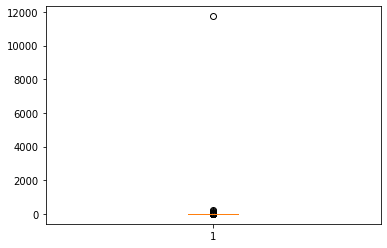

In [5]:
print(df['target'].describe().apply(lambda x:round(x,3)))
plt.boxplot(df['target'].dropna())

In [6]:
# IQR Filter
Q3 = df['target'].quantile(0.75)
Q1 = df['target'].quantile(0.25)
IQR = Q3 - Q1
C = (df['target']<Q1-1.5*IQR)|(df['target']>Q3+1.5*IQR)
out_idx = df.loc[C].index.tolist()
df = df.drop(out_idx)

count    136417.000000
mean          0.907719
std           0.012385
min           0.872430
25%           0.899626
50%           0.907436
75%           0.915680
max           0.943909
Name: target, dtype: float64


{'whiskers': [<matplotlib.lines.Line2D at 0x7f1e3cddaa58>,
 'caps': [<matplotlib.lines.Line2D at 0x7f1e3ce8e160>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f1e3cdda908>],
 'medians': [<matplotlib.lines.Line2D at 0x7f1e3ce8e7f0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f1e3ce8eb38>],
 'means': []}

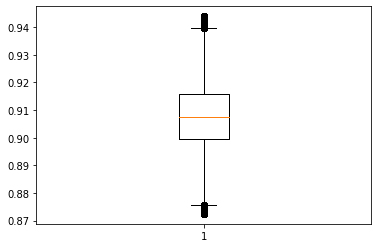

In [7]:
print(df['target'].describe())
plt.boxplot(df['target'].dropna())

In [8]:
# Quantile Filter
ub = df['target'].quantile(0.95)
lb = df['target'].quantile(0.05)
C = (df['target']<lb)|(df['target']>ub)
out_idx = df.loc[C].index.tolist()
df = df.drop(out_idx)

count    122775.000000
mean          0.907689
std           0.009628
min           0.887305
25%           0.900451
50%           0.907436
75%           0.914657
max           0.928830
Name: target, dtype: float64


{'whiskers': [<matplotlib.lines.Line2D at 0x7f1e3c83afd0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f1e3c82c6d8>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f1e3c83ae80>],
 'medians': [<matplotlib.lines.Line2D at 0x7f1e3c82cd68>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f1e3c8210f0>],
 'means': []}

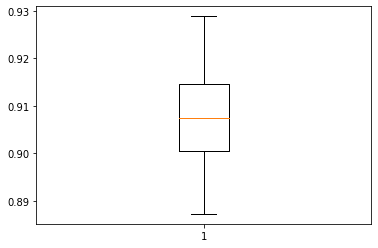

In [9]:
print(df['target'].describe())
plt.boxplot(df['target'].dropna())

In [10]:
# dropna
print(df.shape)
df = df.dropna(subset=['target'])
print(df.shape)

(168115, 92)
(122775, 92)


# scaler features

In [11]:
from sklearn.preprocessing import StandardScaler
import warnings;warnings.simplefilter('ignore')

sc = StandardScaler()
x_col = df.drop('target',axis=1).columns.tolist()
df[x_col] = sc.fit_transform(df[x_col])
df.head()

,MLPAP_TI-0706B02,MLPAP_TI-0706B03,MLPAP_TI-0706B04,MLPAP_TI-0706B05,MLPAP_TI-0706B06,MLPAP_TI-0706B07,MLPAP_TI-0706B08,MLPAP_TI-0706B09,MLPAP_TI-0706B10,MLPAP_TI-0706B11,...,DATA OF USE,MLPAP_FR-0755.PV,MLPAP_FR-0755PV(轉換後),MLPAP_FR-0791.PV,MLPAP_FI-V211.PV,MLPAP_FI-V211.PV(轉換後),MLPAP_PI-0658.PV,MLPAP_TIC-0757.PV,MLPAP_V125-PHD,target
2016-05-10 08:10:00,7.972448,4.162851,2.293976,1.072124,0.766800,0.231921,-0.682200,-1.065706,-0.883078,-0.223328,...,-1.638559,-2.619894,-2.619894,-7.953859,-0.488097,-0.488097,-4.022760,-1.015438,-0.088287,0.914125
2016-05-10 08:20:00,7.972448,4.169368,2.293976,1.104863,0.766800,0.239997,-0.682200,-1.065706,-0.883078,-0.223328,...,-1.638539,-2.614712,-2.614712,-7.928778,-0.488097,-0.488097,-4.029037,-0.982340,-0.088287,0.919765
2016-05-10 08:30:00,7.972448,4.179456,2.293976,1.086815,0.766800,0.231921,-0.682200,-1.065706,-0.883078,-0.223328,...,-1.638520,-2.617016,-2.617016,-7.933165,-0.488097,-0.488097,-4.016871,-0.975999,-0.088287,0.926346
2016-05-10 23:40:00,7.779224,4.640855,2.691496,1.402497,0.907968,0.393274,-0.902479,-1.745061,-1.508446,-0.860335,...,-1.636747,-2.612469,-2.612469,-6.819152,-0.488097,-0.488097,-2.797698,-0.840360,-0.088287,0.906781
2016-05-10 23:50:00,7.808192,4.671687,2.730111,1.402497,0.907968,0.393274,-0.902479,-1.745061,-1.443246,-0.860335,...,-1.636728,-2.620588,-2.620588,-6.875312,-0.488097,-0.488097,-2.798826,-0.868595,-0.088287,0.926688


# Removing features with low variance

In [12]:
import statistics as stat

v_lst = pd.DataFrame()
for c in tqdm(x_col):
    v_lst.loc[c,'var'] = stat.variance(df[c])

In [13]:
v_lst.sort_values(by='var').head()

,var
MLPAP_TJR-0715B2.PV,1.000008
MLPAP_TI-0706B01,1.000008
MLPAP_TI-0706B03,1.000008
MLPAP_FI-V211.PV,1.000008
MLPAP_TI-0716A17,1.000008


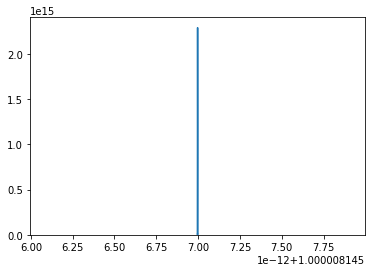

In [14]:
sns.distplot(v_lst)

# corr

In [15]:
df.iloc[:,10:20].corr().style.background_gradient()

,MLPAP_TI-0706B12,MLPAP_TI-0706B13,MLPAP_TI-0706B14,MLPAP_TI-0706B15,MLPAP_TI-0706B16,MLPAP_TI-0706B17,MLPAP_TI-0706B18,MLPAP_TI-0706B19,MLPAP_TI-0706B20,MLPAP_TI-0706B21
MLPAP_TI-0706B12,1,0.952126,0.959295,0.608692,0.933759,0.87988,0.787509,0.714089,0.625214,0.147544
MLPAP_TI-0706B13,0.952126,1,0.996574,0.641871,0.993309,0.977991,0.929335,0.877353,0.808782,0.214039
MLPAP_TI-0706B14,0.959295,0.996574,1,0.664893,0.995229,0.972873,0.915417,0.857756,0.782809,0.213033
MLPAP_TI-0706B15,0.608692,0.641871,0.664893,1,0.673847,0.656885,0.619613,0.603907,0.562396,0.222852
MLPAP_TI-0706B16,0.933759,0.993309,0.995229,0.673847,1,0.988508,0.944282,0.894574,0.826835,0.235255
MLPAP_TI-0706B17,0.87988,0.977991,0.972873,0.656885,0.988508,1,0.982222,0.949241,0.898095,0.258481
MLPAP_TI-0706B18,0.787509,0.929335,0.915417,0.619613,0.944282,0.982222,1,0.988908,0.960743,0.278463
MLPAP_TI-0706B19,0.714089,0.877353,0.857756,0.603907,0.894574,0.949241,0.988908,1,0.989158,0.290222
MLPAP_TI-0706B20,0.625214,0.808782,0.782809,0.562396,0.826835,0.898095,0.960743,0.989158,1,0.293329
MLPAP_TI-0706B21,0.147544,0.214039,0.213033,0.222852,0.235255,0.258481,0.278463,0.290222,0.293329,1


# 處裡共線性

In [16]:
corrs = abs(df.corr())
threshold = 0.8
above_threshold_vars = {}
for col in corrs:
    above_threshold_vars[col] = list(corrs.index[corrs[col] > threshold])

In [17]:
cols_to_remove = []
cols_seen = []
cols_to_remove_pair = []

for key, value in above_threshold_vars.items():
    cols_seen.append(key)
    for x in value:
        if x == key:
            next
        else:
            if x not in cols_seen:
                cols_to_remove.append(x)
                cols_to_remove_pair.append(key)            
cols_to_remove = list(set(cols_to_remove))
print('Number of columns to remove: ', len(cols_to_remove))

Number of columns to remove:  66


In [18]:
# do remove
df = df.drop(cols_to_remove,axis=1)

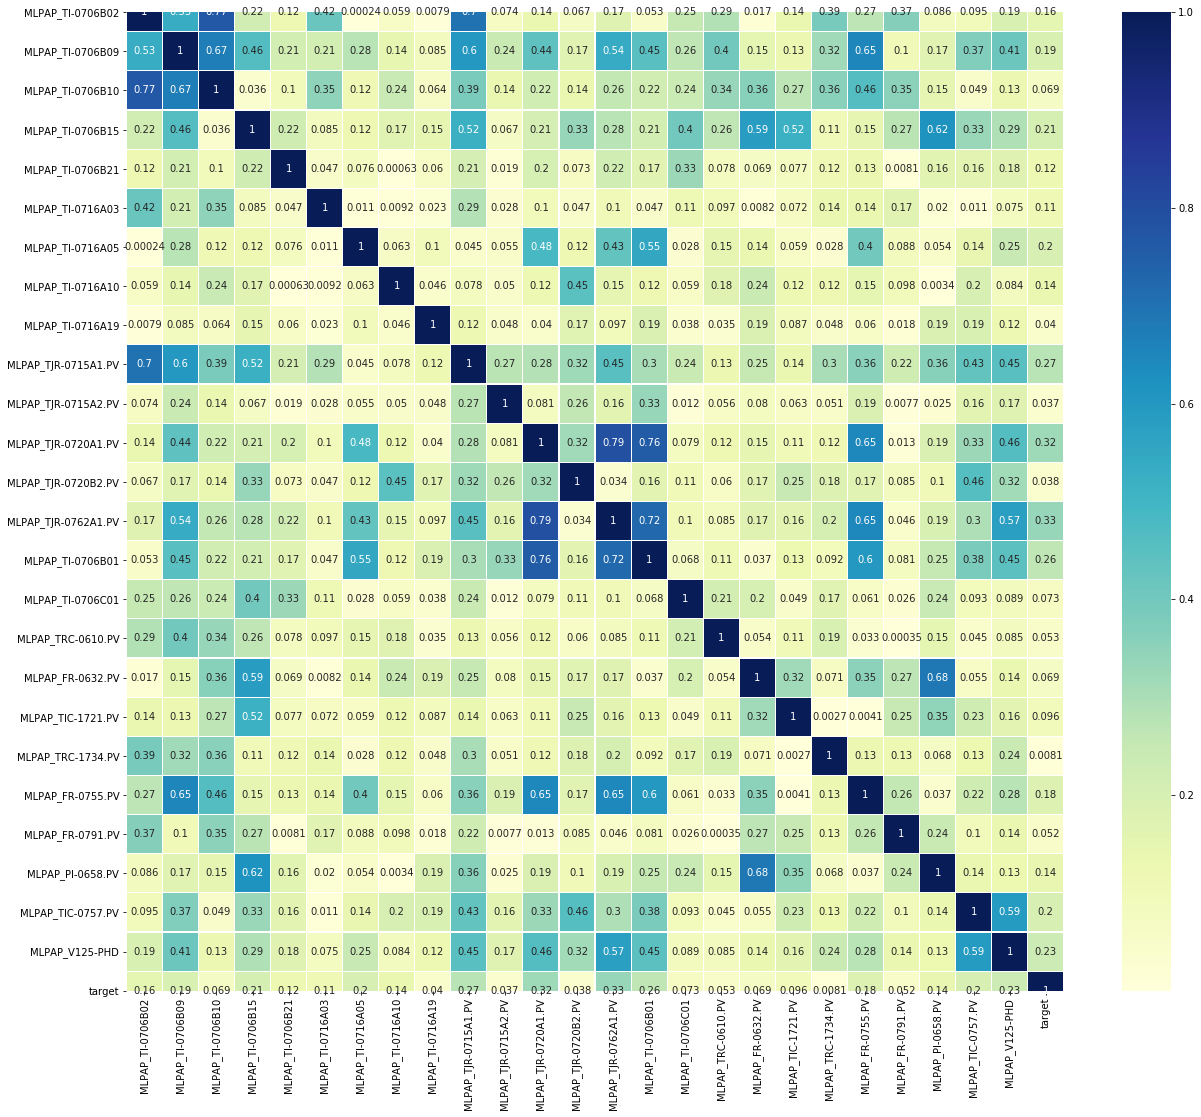

In [19]:
# after remove check corr
fig = plt.figure(figsize=(21,18))
sns.heatmap(abs(df.corr()),annot=True,linewidths=0.1,cmap='YlGnBu')

# Recursive Feature Elimination

In [20]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

rfe = RFE(estimator = LinearRegression(),
          n_features_to_select = 15)

X = df
y = df['target']

new_X = rfe.fit_transform(X,y)
new_X = pd.DataFrame(new_X,columns = X.columns[rfe.get_support()])
new_X.head()

,MLPAP_TI-0706B15,MLPAP_TI-0706B21,MLPAP_TI-0716A03,MLPAP_TI-0716A05,MLPAP_TJR-0720A1.PV,MLPAP_TJR-0720B2.PV,MLPAP_TJR-0762A1.PV,MLPAP_TI-0706B01,MLPAP_TRC-0610.PV,MLPAP_TIC-1721.PV,MLPAP_TRC-1734.PV,MLPAP_FR-0755.PV,MLPAP_TIC-0757.PV,MLPAP_V125-PHD,target
0,0.436520,0.527857,2.885848,0.448321,0.677295,0.881300,0.796872,0.633992,3.036852,3.099501,0.608934,-2.619894,-1.015438,-0.088287,0.914125
1,0.436520,0.527857,2.885848,0.448321,0.677122,0.881648,0.797089,0.633992,2.864041,3.272350,0.447358,-2.614712,-0.982340,-0.088287,0.919765
2,0.436830,0.527857,2.885848,0.448321,0.677619,0.881571,0.796987,0.633992,3.006620,3.596289,-0.634915,-2.617016,-0.975999,-0.088287,0.926346
3,0.411821,0.395807,2.856863,0.468480,0.641630,0.853312,0.763786,0.601863,1.710665,3.361869,0.769126,-2.612469,-0.840360,-0.088287,0.906781
4,0.412131,0.395807,2.882331,0.468480,0.642077,0.853810,0.764300,0.603356,1.822449,3.029603,0.528846,-2.620588,-0.868595,-0.088287,0.926688


In [21]:
df = new_X

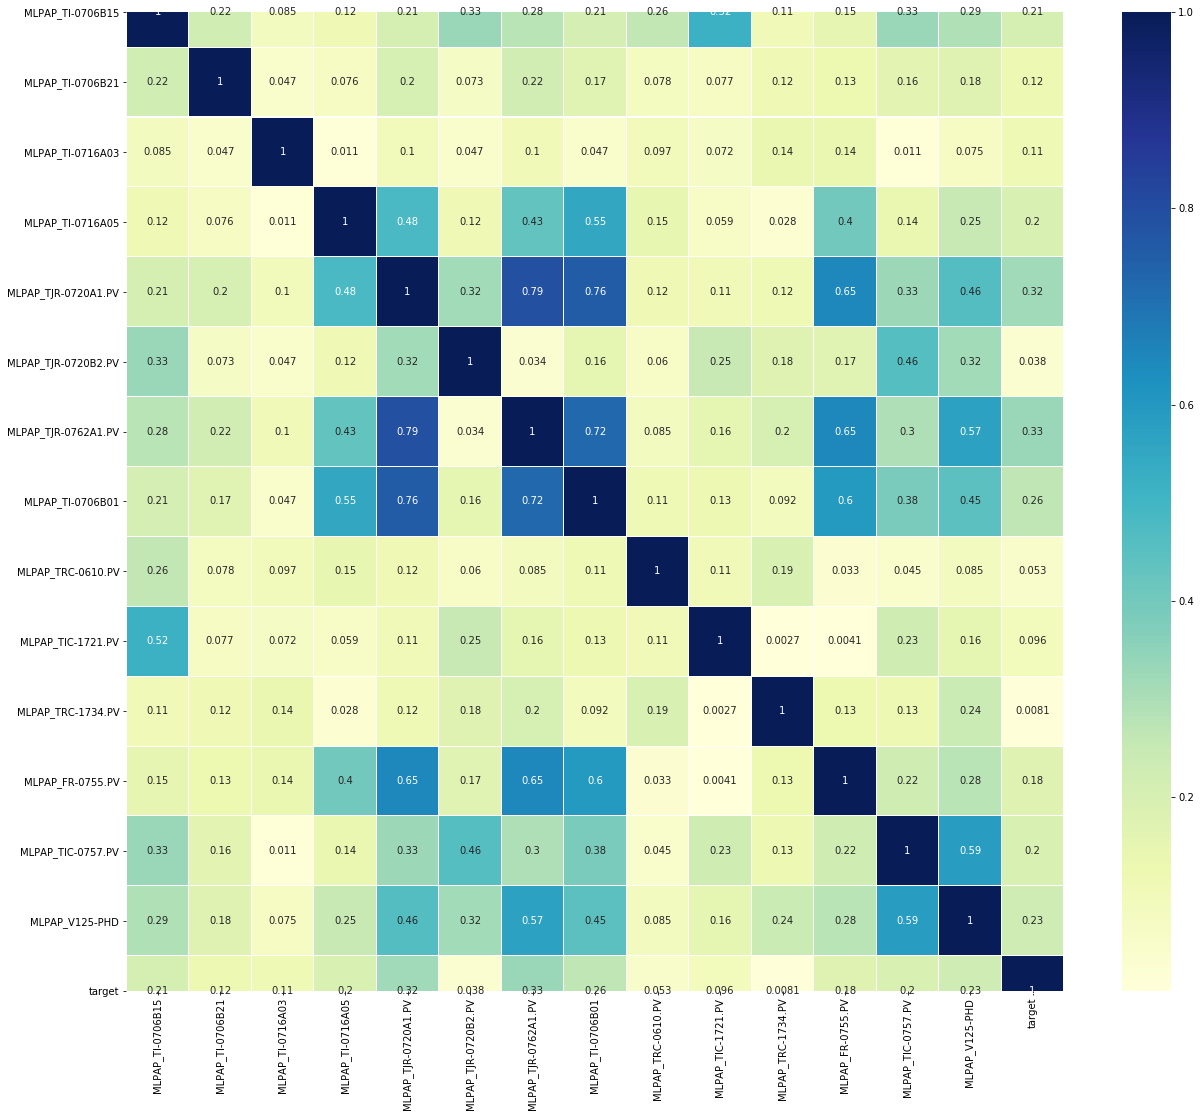

In [22]:
fig = plt.figure(figsize=(21,18))
sns.heatmap(abs(df.corr()),annot=True,linewidths=0.1,cmap='YlGnBu')

In [23]:
print(df.shape)
print(df.isnull().sum().sum())
df.head()

(122775, 15)
0


,MLPAP_TI-0706B15,MLPAP_TI-0706B21,MLPAP_TI-0716A03,MLPAP_TI-0716A05,MLPAP_TJR-0720A1.PV,MLPAP_TJR-0720B2.PV,MLPAP_TJR-0762A1.PV,MLPAP_TI-0706B01,MLPAP_TRC-0610.PV,MLPAP_TIC-1721.PV,MLPAP_TRC-1734.PV,MLPAP_FR-0755.PV,MLPAP_TIC-0757.PV,MLPAP_V125-PHD,target
0,0.436520,0.527857,2.885848,0.448321,0.677295,0.881300,0.796872,0.633992,3.036852,3.099501,0.608934,-2.619894,-1.015438,-0.088287,0.914125
1,0.436520,0.527857,2.885848,0.448321,0.677122,0.881648,0.797089,0.633992,2.864041,3.272350,0.447358,-2.614712,-0.982340,-0.088287,0.919765
2,0.436830,0.527857,2.885848,0.448321,0.677619,0.881571,0.796987,0.633992,3.006620,3.596289,-0.634915,-2.617016,-0.975999,-0.088287,0.926346
3,0.411821,0.395807,2.856863,0.468480,0.641630,0.853312,0.763786,0.601863,1.710665,3.361869,0.769126,-2.612469,-0.840360,-0.088287,0.906781
4,0.412131,0.395807,2.882331,0.468480,0.642077,0.853810,0.764300,0.603356,1.822449,3.029603,0.528846,-2.620588,-0.868595,-0.088287,0.926688


# save

In [24]:
df.to_csv('./train_FeatureSelected.csv')